In [9]:
import torch
import numpy as np
from torch import nn

# 准备训练数据
data = np.array([[5.4000, 6.6151],
        [2.7000, 6.5032],
        [2.4300, 6.4790],
        [2.1600, 6.4495],
        [1.8900, 6.4122],
        [1.6200, 6.3630],
        [1.3500, 6.2926],
        [1.2150, 6.2451],
        [1.0800, 6.1847],
        [0.9450, 6.1064],
        [0.8100, 5.9981],
        [0.6750, 5.8333],
        [0.5400, 5.5598],
        [0.4050, 4.9695],
        [0.3942, 4.8904],
        [0.3834, 4.8026],
        [0.3726, 4.7045],
        [0.3618, 4.5947],
        [0.3510, 4.4704],
        [0.3402, 4.3301],
        [0.3294, 4.1690],
        [0.3186, 3.9722],
        [0.3078, 3.7309],
        [0.2970, 3.4317],
        [0.2862, 3.0129],
        [0.2754, 2.3064],
        [0.2700, 1.0896],
        [0.2646, 0.2089],
        [0.2538, 0.1331],
        [0.2430, 0.0942],
        [0.2322, 0.0689],
        [0.2214, 0.0502],
        [0.2106, 0.0364],
        [0.1998, 0.0254],
        [0.1890, 0.0164]])

T_train = data[:, 0]  # 输入数据 T
S_train = data[:, 1]  # 目标输出数据 S

# 转换为 PyTorch 张量并调整形状
T_tensor = torch.tensor(T_train, dtype=torch.float32).unsqueeze(1)
S_tensor = torch.tensor(S_train, dtype=torch.float32).unsqueeze(1)

# 构建神经网络模型
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Sigmoid(),
            nn.Linear(64, 128),
            nn.Sigmoid(),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.net(x)

model1 = Model1()

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

# 训练模型
for epoch in range(30000):
    outputs = model1(T_tensor)
    loss = criterion(outputs, S_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 5000 == 0:
        print(f'Epoch {epoch + 1}: Loss = {loss.item():.4f}')

torch.save({
    'model_state': model1.state_dict(),
    'optimizer_state': optimizer.state_dict()
}, 'model1_checkpoint.pth')

Epoch 5000: Loss = 0.0027
Epoch 10000: Loss = 0.0001
Epoch 15000: Loss = 0.0000
Epoch 20000: Loss = 0.0000
Epoch 25000: Loss = 0.0000
Epoch 30000: Loss = 0.0000


In [10]:
import torch
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import ExponentialLR
import copy 
# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#%% 构建模型AA 
class ModelAA(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Sigmoid(),
            nn.Linear(64, 128),
            nn.Sigmoid(),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # 输出范围[0, 1]
        )
        
    def forward(self, x):
        scaled_output = -10 * self.net(x)  
        return x * scaled_output

model_AA = ModelAA().to(device)

#%% 预生成采样点
n_points = 200
s = np.linspace(0, 1, n_points)**3
zh_values = 0.1 + s * (3.0 - 0.1)
zh_tensor = torch.tensor(zh_values, dtype=torch.float32, device=device).unsqueeze(1)

#%% 数值积分计算
def compute_T(zh):
    num_points = 500
    batch_size = zh.size(0)
    
    # 生成积分点
    t = torch.linspace(0, 1, num_points, device=device)
    x = zh * t.view(1, -1)  # [batch, num_points]
    
    # 展平处理
    x_flat = x.view(-1, 1)
    a_flat = model_AA(x_flat)
    a_values = a_flat.view(batch_size, num_points)
    
    # 数值稳定
    x_safe = torch.clamp(x, min=1e-12)
    a_safe = torch.clamp(a_values, min=-10.0, max=0.0)
    
    # 积分计算
    integrand = x_safe**3 * torch.exp(-3.0 * a_safe)
    integral = torch.sum(integrand, dim=1) * (zh.squeeze() / (num_points - 1))
    integral = torch.clamp(integral, min=1e-20)
    
    # 最终计算
    a_z = model_AA(zh)
    a_z = torch.clamp(a_z, min=-10.0, max=0.0)
    numerator = zh.squeeze()**3 * torch.exp(-3.0 * a_z.squeeze())
    return (numerator / (4.0 * np.pi * integral)).view(-1, 1)

#%% 加载预训练model1
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Sigmoid(),
            nn.Linear(64, 128),
            nn.Sigmoid(),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.net(x)

model1 = Model1().to(device)
model1.load_state_dict(torch.load('model1_checkpoint.pth')['model_state'])
model1.eval()

#%% 训练配置
G = nn.Parameter(torch.tensor([1.4], device=device), requires_grad=True)

optimizer = optim.AdamW([
    {'params': model_AA.parameters()},
    {'params': [G], 'weight_decay': 0}  
], lr=0.01, weight_decay=1e-4)

scheduler = ExponentialLR(optimizer, gamma=0.95)

#%% 优化过程
def compute_loss(G):
    T_values = compute_T(zh_tensor)
    with torch.no_grad():
        S_pred = model1(T_values).squeeze()
    
    # 理论值计算
    a_values = model_AA(zh_tensor).squeeze()
    exp_term = torch.exp(3.0 * a_values)
    zh_safe = torch.clamp(zh_tensor.squeeze(), min=1e-8)
    S_theory = exp_term / (4.0 * G * zh_safe**3)
    
    # 调整计算
    T_cubed = torch.clamp(T_values.squeeze()**3, min=1e-16)
    adjusted_S = S_theory / T_cubed
    return F.mse_loss(adjusted_S, S_pred) 

def train_step():
    optimizer.zero_grad()
    
    # 前向传播
    loss = compute_loss(G)
    
    # 反向传播
    loss.backward()
    
    # 梯度处理
    torch.nn.utils.clip_grad_norm_(model_AA.parameters(), 5.0)
    if G.grad is not None:
        G.grad = torch.nan_to_num(G.grad)
    
    # 参数更新
    optimizer.step()
    
    # 应用约束
    with torch.no_grad():
        G.data.clamp_(1.0, 1.5)
    
    return loss.item()

#%% 训练循环
best_loss = float('inf')
best_model_state = None
best_G = None

for epoch in range(3000):
    loss = train_step()  
    
    # 更新最佳模型和G值
    if loss < best_loss:
        best_loss = loss
        best_model_state = copy.deepcopy(model_AA.state_dict())
        best_G = G.data.clone()
        #print(f"Epoch {epoch}: New best loss: {best_loss:.6f}, G: {best_G.item():.4f}")
    
    # 学习率更新
    if (epoch + 1) % 50 == 0:
        scheduler.step()
    
    # 日志输出
    if epoch % 500 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss:.6f} | G: {G.item():.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

#%% 保存最佳模型和G值
torch.save({
    'model_state': best_model_state,
    'G_state': best_G,
}, 'model_AA_best_checkpoint.pth')

print(f"Best G value: {best_G.item():.4f}")

Epoch    0 | Loss: 36.528385 | G: 1.3900 | LR: 0.010000
Epoch  500 | Loss: 0.019719 | G: 1.1344 | LR: 0.005987
Epoch 1000 | Loss: 0.007902 | G: 1.1549 | LR: 0.003585
Epoch 1500 | Loss: 0.006673 | G: 1.1583 | LR: 0.002146
Epoch 2000 | Loss: 0.005790 | G: 1.1599 | LR: 0.001285
Epoch 2500 | Loss: 0.005404 | G: 1.1610 | LR: 0.000769
Best G value: 1.1616


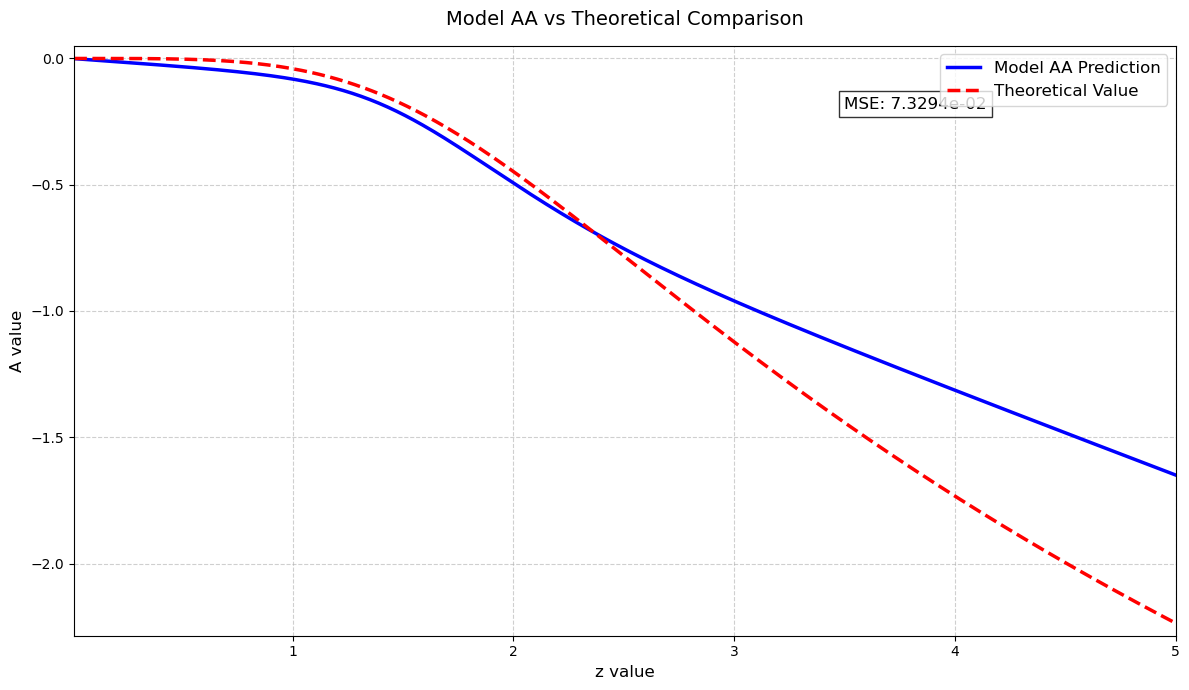

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 生成测试数据范围
z_plot = np.linspace(0.01, 5.0, 500).reshape(-1, 1)

# 转换为PyTorch张量并送入选定设备
z_tensor = torch.tensor(z_plot, dtype=torch.float32, device=device)

# 模型推断
model_AA.eval()
with torch.no_grad():
    A_model = model_AA(z_tensor).cpu().numpy()

# 理论值计算
A_theory = -0.584 * np.log(0.072 * z_plot**4 + 1)

# 可视化对比
plt.figure(figsize=(12, 7), dpi=100)

# 绘制曲线
plt.plot(z_plot, A_model, 'b-', linewidth=2.5, label='Model AA Prediction')
plt.plot(z_plot, A_theory, 'r--', linewidth=2.5, label='Theoretical Value')

# 添加误差统计
mse = np.mean((A_model - A_theory)**2)
plt.text(3.5, -0.2, f'MSE: {mse:.4e}', fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

# 图表装饰
plt.title('Model AA vs Theoretical Comparison', fontsize=14, pad=15)
plt.xlabel('z value', fontsize=12)
plt.ylabel('A value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# 设置坐标轴范围
plt.xlim(z_plot.min(), z_plot.max())
plt.ylim(min(A_model.min(), A_theory.min())-0.05, 
         max(A_model.max(), A_theory.max())+0.05)

# 显示图表
plt.tight_layout()
plt.show()

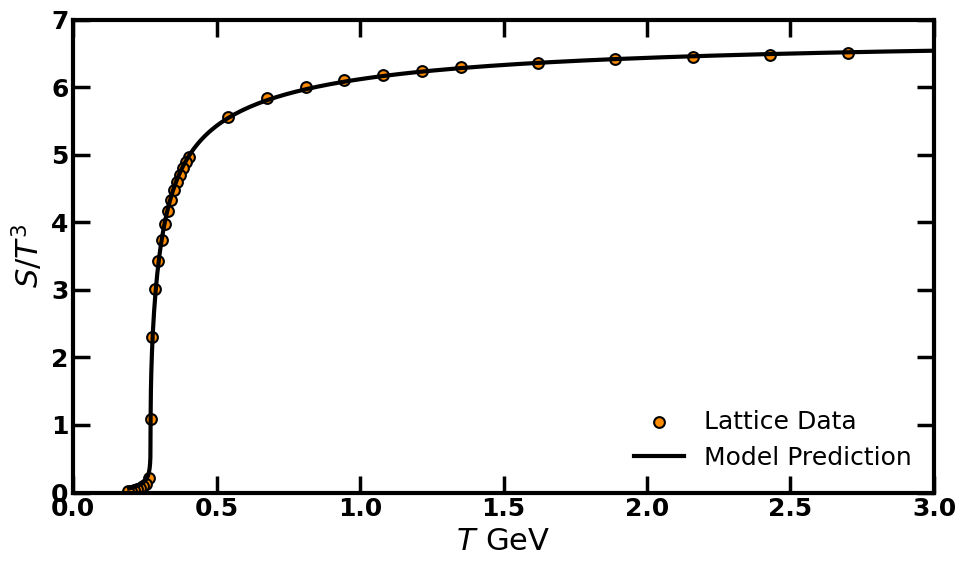

In [12]:
import matplotlib.pyplot as plt
import torch

# Ensure model is in evaluation mode
model_AA.eval()

with torch.no_grad():
    # Compute all T values and adjusted S for zh
    T_values = compute_T(zh_tensor)
    a_values = model_AA(zh_tensor).squeeze()
    exp_term = torch.exp(3.0 * a_values)
    zh_safe = torch.clamp(zh_tensor.squeeze(), min=1e-8)
    S_theory = exp_term / (4.0 * G * zh_safe**3)
    T_cubed = T_values.squeeze() ** 3
    adjusted_S = S_theory / T_cubed

    # Convert to numpy arrays
    T_np = T_values.cpu().numpy().squeeze()
    adjusted_S_np = adjusted_S.cpu().numpy().squeeze()

# Set up the plot with the desired style
plt.figure(figsize=(10, 6))

# Plot original data with larger markers and darker color
plt.scatter(data[:,0], data[:,1], 
           c='darkorange', s=60, edgecolor='k', linewidth=1.5,  
           alpha=1.0, label='Lattice Data') 

# Plot theoretical curve with thicker line
plt.plot(T_np, adjusted_S_np, 
        color='Black', linewidth=3,  
        label='Model Prediction')

# Set axis labels with larger bold fonts
plt.xlabel(r'$\mathit{T}$ $\rm GeV$', fontsize=22, fontweight='bold')
plt.ylabel(r'$\mathit{S/T^3}$', fontsize=22, fontweight='bold') 
plt.legend(fontsize=18, frameon=False)  

# Set axis limits 
plt.xlim(0, 3)
plt.ylim(0, 7)

# Set tick style and axis borders - with thicker ticks
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.xticks(fontsize=18, fontweight='bold')  
plt.yticks(fontsize=18, fontweight='bold') 
plt.tick_params(axis='both', which='major', 
               direction='in',
               length=12,  
               width=2.5, 
               bottom=True, top=True, left=True, right=True)

# Set text and font - with global bold setting
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=18, weight='bold')  

# Set border line width - thicker borders
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(3.0)  

plt.tight_layout()

# Save as EPS format with high resolution
plt.savefig('S_T3_plot.eps', format='eps', dpi=1000, transparent=False)
plt.show()

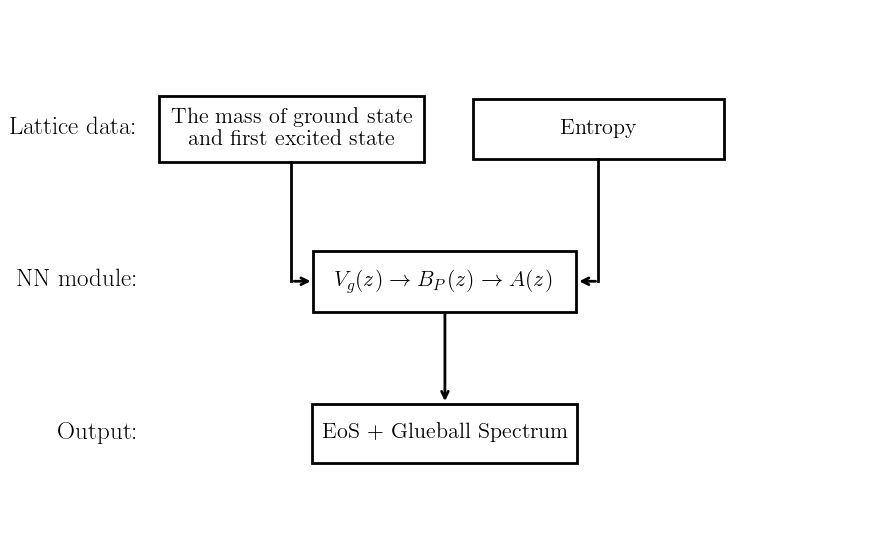

In [90]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

def draw_boxed_text(ax, text, center, fontsize=16, pad_x=0.5, pad_y=0.3, extra_frac=0.08):
    x, y = center
    fig = ax.figure

    # 临时透明文字用于测量
    t_temp = ax.text(x, y, text, fontsize=fontsize, fontweight='bold',
                     ha='center', va='center', alpha=0, zorder=0)
    
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    bbox_disp = t_temp.get_window_extent(renderer=renderer)  # display coords (pixels)
    # 转换到 data coordinates
    bbox_data = bbox_disp.transformed(ax.transData.inverted())
    text_w = bbox_data.width
    text_h = bbox_data.height
    # 移除临时文字
    t_temp.remove()

    # 计算方框大小，加入 pad 与额外裕量
    width = text_w + pad_x + extra_frac * text_w
    height = text_h + pad_y + extra_frac * text_h

    # 绘制矩形与最终文字
    rect = plt.Rectangle((x - width/2, y - height/2), width, height,
                         facecolor='white', edgecolor='black', linewidth=2, zorder=1)
    ax.add_patch(rect)
    ax.text(x, y, text, fontsize=fontsize, fontweight='bold',
            ha='center', va='center', zorder=2)

    return width, height

def create_flow_chart():
    fig, ax = plt.subplots(figsize=(11, 7))  
    ax.set_facecolor('white')

    # LaTeX 渲染
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
    })

    # 增大横向放大倍数（显著增加 pad_x）
    HORIZONTAL_SCALE = 4

    # 调整节点位置以增大第一行两个方框的距离
    pos = {
        "The mass of ground state\nand first excited state": (-2.5, 3.5),  
        "Entropy": (2.5, 3.5),  
    }
    # A(z) 放在两个上方框中间，下面的 Output 与其垂直对齐
    a_x = (pos["The mass of ground state\nand first excited state"][0] + pos["Entropy"][0]) / 2
    pos[r"$V_g(z) \rightarrow B_P(z) \rightarrow A(z)$"] = (a_x, 2.5)
    pos["EoS + Glueball Spectrum"] = (a_x, 1.5)

    # 绘制方框并记录尺寸
    box_sizes = {}
    for label, (x, y) in pos.items():
        w, h = draw_boxed_text(ax, label, (x, y), fontsize=16,
                               pad_x=1 * HORIZONTAL_SCALE, pad_y=0.35, extra_frac=0.10)
        box_sizes[label] = (w, h)

    a_label = r"$V_g(z) \rightarrow B_P(z) \rightarrow A(z)$"
    aw, ah = box_sizes[a_label]
    a_center = pos[a_label]

    # 上左 → A(z) 左边
    g_center = pos["The mass of ground state\nand first excited state"]
    g_bottom = (g_center[0], g_center[1] - box_sizes["The mass of ground state\nand first excited state"][1] / 2)
    a_left_edge = (a_center[0] - aw / 2, a_center[1])
    ax.plot([g_bottom[0], g_bottom[0]], [g_bottom[1], a_left_edge[1]], color="black", linewidth=2)
    ax.annotate("", xy=(a_left_edge[0], a_left_edge[1]),
                xytext=(g_bottom[0], a_left_edge[1]),
                arrowprops=dict(arrowstyle="->", color="black", linewidth=2))

    e_center = pos["Entropy"]
    e_bottom = (e_center[0], e_center[1] - box_sizes["Entropy"][1] / 2)
    a_right_edge = (a_center[0] + aw / 2, a_center[1])
    ax.plot([e_bottom[0], e_bottom[0]], [e_bottom[1], a_right_edge[1]], color="black", linewidth=2)
    ax.annotate("", xy=(a_right_edge[0], a_right_edge[1]),
                xytext=(e_bottom[0], a_right_edge[1]),
                arrowprops=dict(arrowstyle="->", color="black", linewidth=2))

    # A(z) → Output
    o_top = (pos["EoS + Glueball Spectrum"][0],
             pos["EoS + Glueball Spectrum"][1] + box_sizes["EoS + Glueball Spectrum"][1] / 2)
    a_bottom = (a_center[0], a_center[1] - ah / 2)
    ax.annotate("", xy=o_top, xytext=a_bottom,
                arrowprops=dict(arrowstyle="->", color="black", linewidth=2))

    
    min_x = min([p[0] for p in pos.values()])
    ax.text(min_x - 2.5, 3.5, "Lattice data:", fontsize=18, fontweight='bold', va='center', ha='right')
    ax.text(min_x - 2.5, 2.5, "NN module:", fontsize=18, fontweight='bold', va='center', ha='right')
    ax.text(min_x - 2.5, 1.5, "Output:", fontsize=18, fontweight='bold', va='center', ha='right')

    
    lefts = [pos[k][0] - box_sizes[k][0] / 2 for k in pos]
    rights = [pos[k][0] + box_sizes[k][0] / 2 for k in pos]
    bottoms = [pos[k][1] - box_sizes[k][1] / 2 for k in pos]
    tops = [pos[k][1] + box_sizes[k][1] / 2 for k in pos]

    x_margin = 0.2 * (max(rights) - min(lefts) + 1e-6)
    y_margin = 0.15 * (max(tops) - min(bottoms) + 1e-6)
    ax.set_xlim(min(lefts) - x_margin - 0.5, max(rights) + x_margin + 0.5)
    ax.set_ylim(min(bottoms) - y_margin - 0.2, max(tops) + y_margin + 0.2)

    ax.axis('off')

    plt.savefig("flow_chart.eps", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

create_flow_chart()

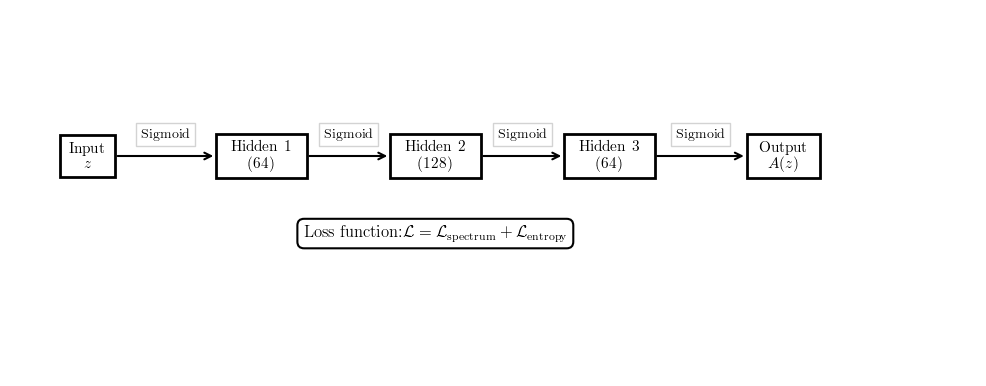

In [122]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# 创建图形
plt.figure(figsize=(10, 4.0), dpi=100)
ax = plt.gca()
ax.axis('off')

# 定义层的位置
layers = [
    {"name": "Input\n$z$", "x": 0.08, "y": 0.6},
    {"name": "Hidden 1\n(64)", "x": 0.26, "y": 0.6},
    {"name": "Hidden 2\n(128)", "x": 0.44, "y": 0.6},
    {"name": "Hidden 3\n(64)", "x": 0.62, "y": 0.6},
    {"name": "Output\n$A(z)$", "x": 0.8, "y": 0.6}
]

# 绘制层
boxes = []  # 存储方框对象
for layer in layers:
    # 计算文本所需尺寸
    text = plt.text(layer["x"], layer["y"], layer["name"], 
                   ha='center', va='center', fontsize=11)
    
    # 获取文本边界框
    renderer = plt.gcf().canvas.get_renderer()
    bbox = text.get_window_extent(renderer=renderer).transformed(ax.transData.inverted())
    
    # 移除文本
    text.remove()
    
    # 计算方框尺寸
    width = bbox.width * 1.2
    height = bbox.height * 1.2
    
    # 绘制层框
    rect = patches.Rectangle(
        (layer["x"] - width/2, layer["y"] - height/2), 
        width, height,
        linewidth=2.0, edgecolor='black', facecolor='white',
        zorder=3
    )
    ax.add_patch(rect)
    boxes.append(rect)
    
    # 重新添加层标签
    plt.text(layer["x"], layer["y"], layer["name"], 
             ha='center', va='center', fontsize=11, zorder=4)

# 绘制连接箭头和激活函数标注
for i in range(len(layers)-1):
    # 获取前后层的方框
    start_box = boxes[i]
    end_box = boxes[i+1]
    
    # 计算箭头起点和终点
    start_x = start_box.get_x() + start_box.get_width()
    start_y = start_box.get_y() + start_box.get_height()/2
    end_x = end_box.get_x()
    end_y = end_box.get_y() + end_box.get_height()/2
    
    # 绘制箭头
    plt.annotate("", 
                xy=(end_x, end_y), 
                xytext=(start_x, start_y),
                arrowprops=dict(arrowstyle="->", linewidth=1.5, color="black"),
                zorder=2)
    
    # 计算激活函数标注位置
    label_x = (start_x + end_x)/2
    label_y = max(start_box.get_y(), end_box.get_y()) + start_box.get_height()/2 + 0.05
    
    # 在每个连接上标注激活函数（移除透明效果）
    plt.text(label_x, label_y, "Sigmoid", 
             ha='center', fontsize=10, style='italic',
             bbox=dict(facecolor='white', edgecolor='lightgray'))  # 移除alpha参数

# 添加损失函数标注
hidden2_box = boxes[2]  # Hidden 2的方框
loss_y = hidden2_box.get_y() - hidden2_box.get_height()/2 - 0.1

plt.text(hidden2_box.get_x() + hidden2_box.get_width()/2, loss_y, 
         r"Loss function:$\mathcal{L} = \mathcal{L}_{\mathrm{spectrum}} + \mathcal{L}_{\mathrm{entropy}}$", 
         ha='center', fontsize=12,
         bbox=dict(facecolor='white', edgecolor='black', 
                   linewidth=1.5, boxstyle='round,pad=0.4'),
         zorder=5)

# 保存为EPS格式
plt.savefig('nn_architecture_A.eps', format='eps', bbox_inches='tight')

# 显示图像
plt.tight_layout(pad=1.0)
plt.show()